In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
import json
import seaborn as sns

In [2]:
annonimized = pd.read_csv('data/student score regression/main/annonimized.csv')
ck = pd.read_csv('data/student score regression/train/ck-public.csv')
qt = pd.read_csv('data/student score regression/train/qt-public.csv')
th = pd.read_csv('data/student score regression/train/th-public.csv')
tbtl = pd.read_csv('data/student score regression/train/TBTL.csv')

In [3]:
ck_cleaned = ck.dropna()
qt_cleaned = qt.dropna()
th_cleaned = th.dropna()

In [4]:
annonimized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295198 entries, 0 to 295197
Data columns (total 11 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   concat('it001',`assignment_id`)  295198 non-null  object
 1   concat('it001',`problem_id`)     295198 non-null  object
 2   concat('it001', username)        295198 non-null  object
 3   is_final                         295198 non-null  int64 
 4   status                           295198 non-null  object
 5   pre_score                        295198 non-null  int64 
 6   coefficient                      295198 non-null  int64 
 7   concat('it001',`language_id`)    295198 non-null  object
 8   created_at                       295198 non-null  object
 9   updated_at                       295198 non-null  object
 10  judgement                        295198 non-null  object
dtypes: int64(3), object(8)
memory usage: 24.8+ MB


In [5]:
ck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hash    761 non-null    object 
 1   CK      755 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


In [6]:
qt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hash    761 non-null    object
 1   diemqt  755 non-null    object
dtypes: object(2)
memory usage: 12.0+ KB


In [7]:
th.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hash    761 non-null    object
 1   TH      755 non-null    object
dtypes: object(2)
memory usage: 12.0+ KB


In [8]:
tbtl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   username  799 non-null    object 
 1   TBTL      799 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.6+ KB


In [9]:
annonimized.columns = ['assignment_id','problem_id','username','is_final','status','pre_score','coefficient','language_id','created_at','updated_at','judgement']

In [10]:
def process_judgement(judgement_col):
    wrong_count = []
    tle_count = []
    total_time = []
    total_mem = []
    custom_errors = []

    for judgement in judgement_col:
        try:
            # Parse JSON string
            data = json.loads(judgement)

            # Default values
            wrong = 0
            tle = 0
            time_sum = 0
            mem_sum = 0
            errors = 0

            if isinstance(data, dict):
                # Extract WRONG and TLE counts
                verdicts = data.get("verdicts", {})
                if isinstance(verdicts, dict):
                    wrong = verdicts.get("WRONG", 0)
                    tle = verdicts.get("Time Limit Exceeded", 0)
                    errors = len(verdicts) - ("WRONG" in verdicts + "Time Limit Exceeded" in verdicts)

                # Calculate total time and memory
                time_sum = sum(data.get("times", []))
                mem_sum = sum(data.get("mems", []))

            wrong_count.append(wrong)
            tle_count.append(tle)
            total_time.append(time_sum)
            total_mem.append(mem_sum)
            custom_errors.append(errors)
        except (json.JSONDecodeError, TypeError, ValueError):
            # If parsing fails, append default values
            wrong_count.append(0)
            tle_count.append(0)
            total_time.append(0)
            total_mem.append(0)
            custom_errors.append(0)

    return wrong_count, tle_count, total_time, total_mem, custom_errors

In [11]:
annonimized["wrong_count"], annonimized["tle_count"], annonimized["total_time"], annonimized["total_mem"], annonimized["custom_errors"] = process_judgement(annonimized["judgement"])

In [12]:
def process_annonimized(data):
    # Chuyển status thành số
    data["status"] = data["status"].map({"SCORE": 1, "Compilation Error": 0})
    
    # Xử lý thời gian với lỗi được bỏ qua
    data["created_at"] = pd.to_datetime("2023-" + data["created_at"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
    data["updated_at"] = pd.to_datetime("2023-" + data["updated_at"], format="%Y-%m-%d %H:%M:%S", errors="coerce")

    # Loại bỏ các hàng có giá trị thời gian không hợp lệ
    data = data.dropna(subset=["created_at", "updated_at"])

    data["time_diff"] = (data["updated_at"] - data["created_at"]).dt.total_seconds()
    
    data["error_rate"] = data["wrong_count"] / (data["wrong_count"] + 1)
    data["time_per_error"] = data["total_time"] / (data["wrong_count"] + 1)
    data["mem_per_error"] = data["total_mem"] / (data["wrong_count"] + 1)
    data["submit_update_ratio"] = data["time_diff"] / (data["total_time"] + 1)
    data["score_per_time"] = data["pre_score"] / (data["total_time"] + 1)
    data["time_error_ratio"] = data["time_per_error"] / (data["error_rate"] + 1)
    data["mem_time_ratio"] = data["mem_per_error"] / (data["time_per_error"] + 1)
    data["time_diff_pre_score_ratio"] = data["time_diff"] / (data["pre_score"] + 1)
    data["wrong_count_total_time_ratio"] = data["wrong_count"] / (data["total_time"] + 1)
    data["pre_score_wrong_count_ratio"] = data["pre_score"] / (data["wrong_count"] + 1)

    data["total_effort"] = data["total_time"] * data["total_mem"]
    data["error_efficiency"] = data["pre_score"] / (data["wrong_count"] + 1)
    data["time_efficiency"] = data["pre_score"] / (data["time_diff"] + 1)
    data["combined_effort"] = data["time_diff"] * data["wrong_count"] / (data["pre_score"] + 1)
    
    #tổng thời gian của user đó dành ra cho 1 bài toán
    data['total_problem_time'] = data.groupby(['problem_id', 'username']).apply(lambda x: (x['updated_at'] - x['created_at']).dt.total_seconds()).reset_index(drop=True)
    
    #thời gian kể từ lần nộp cuối cùng của mỗi username
    data = data.sort_values(by=['username', 'created_at'])
    data["time_since_last_submission"] = data.groupby("username")["created_at"].diff().dt.total_seconds().fillna(0)
    
    #tỉ lệ thành công cuối cùng của mỗi username
    success_rate = data.groupby("username")["status"].mean()
    data["final_success_rate"] = data["username"].map(success_rate)

    #trung bình thời gian và lỗi theo bài toán
    problem_avg_time = data.groupby("problem_id")["total_time"].mean()
    problem_avg_errors = data.groupby("problem_id")["wrong_count"].mean()
    data["problem_avg_time"] = data["problem_id"].map(problem_avg_time)
    data["problem_avg_errors"] = data["problem_id"].map(problem_avg_errors)

    #Thời gian có trọng số
    data["weighted_time"] = data["total_time"] * data["pre_score"]
    
    #đếm số lần submit của user trong 1 ngày
    data["submissions_per_day"] = data.groupby("username")["created_at"].transform(lambda x: x.dt.date.value_counts().mean())


    # Làm sạch dữ liệu
    numeric_cols = ["pre_score", "time_diff", "wrong_count", "tle_count", "total_time", "total_mem", "custom_errors"]
    for col in numeric_cols:
        data[col] = data[col].apply(lambda x: str(x).strip() if isinstance(x, str) else x)
        data[col] = pd.to_numeric(data[col], errors="coerce")
        data[col] = data[col].fillna(0) 

    # Chọn các cột cần thiết
    features = [
        "is_final", "status", "pre_score", "time_diff", "wrong_count", "tle_count", "total_time", "total_mem", 
        "custom_errors", "error_rate", "time_per_error", "mem_per_error", "submit_update_ratio", "score_per_time", 
        "time_error_ratio", "mem_time_ratio", "time_diff_pre_score_ratio", "wrong_count_total_time_ratio", "pre_score_wrong_count_ratio",
        "total_effort", "error_efficiency", "time_efficiency", "combined_effort","total_problem_time",
        "time_since_last_submission", "final_success_rate", "problem_avg_time", "problem_avg_errors", "weighted_time","submissions_per_day",
    ] 
    return data[features + ["username"]]

In [13]:
annonimized_processed = process_annonimized(annonimized)
annonimized_processed.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_17300\3268199307.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_diff"] = (data["updated_at"] - data["created_at"]).dt.total_seconds()
C:\Users\Admin\AppData\Local\Temp\ipykernel_17300\3268199307.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["error_rate"] = data["wrong_count"] / (data["wrong_count"] + 1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17300\3268199307.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,is_final,status,pre_score,time_diff,wrong_count,tle_count,total_time,total_mem,custom_errors,error_rate,...,time_efficiency,combined_effort,total_problem_time,time_since_last_submission,final_success_rate,problem_avg_time,problem_avg_errors,weighted_time,submissions_per_day,username
173048,0,1.0,7000,769.0,0,0,0.0,0,0,0.0,...,9.090909,0.0,136.0,0.0,0.809524,0.000147,0.0,0.0,10.5,00b6dd4fc7eb817e03708c532016ef30ce564a61
173049,0,0.0,0,1.0,0,0,0.0,0,0,0.0,...,0.000000,0.0,9.0,487.0,0.809524,0.000147,0.0,0.0,10.5,00b6dd4fc7eb817e03708c532016ef30ce564a61
173050,0,1.0,7000,7.0,0,0,0.0,0,0,0.0,...,875.000000,0.0,612010.0,15.0,0.809524,0.000147,0.0,0.0,10.5,00b6dd4fc7eb817e03708c532016ef30ce564a61
173051,1,1.0,10000,7.0,0,0,0.0,0,0,0.0,...,1250.000000,0.0,3.0,260.0,0.809524,0.000147,0.0,0.0,10.5,00b6dd4fc7eb817e03708c532016ef30ce564a61
173052,0,0.0,0,555.0,0,0,0.0,0,0,0.0,...,0.000000,0.0,2.0,1135.0,0.809524,0.000000,0.0,0.0,10.5,00b6dd4fc7eb817e03708c532016ef30ce564a61


In [14]:
annonimized_processed.tail()

,is_final,status,pre_score,time_diff,wrong_count,tle_count,total_time,total_mem,custom_errors,error_rate,...,time_efficiency,combined_effort,total_problem_time,time_since_last_submission,final_success_rate,problem_avg_time,problem_avg_errors,weighted_time,submissions_per_day,username
160053,1,1.0,10000,7.0,0,0,0.0,0,0,0.0,...,1250.000000,0.0,7.0,1670.0,0.879699,0.0,0.0,0.0,15.346154,ffe872165621d735a48bb5db0c71dd5195cba359
160054,0,1.0,10000,7.0,0,0,0.0,0,0,0.0,...,1250.000000,0.0,7.0,743.0,0.879699,0.0,0.0,0.0,15.346154,ffe872165621d735a48bb5db0c71dd5195cba359
160055,1,1.0,10000,8.0,0,0,0.0,0,0,0.0,...,1111.111111,0.0,6.0,358.0,0.879699,0.0,0.0,0.0,15.346154,ffe872165621d735a48bb5db0c71dd5195cba359
160056,0,1.0,8000,33.0,0,0,0.0,0,0,0.0,...,235.294118,0.0,153.0,689.0,0.879699,0.0,0.0,0.0,15.346154,ffe872165621d735a48bb5db0c71dd5195cba359
160057,1,1.0,10000,7.0,0,0,0.0,0,0,0.0,...,1250.000000,0.0,2.0,26.0,0.879699,0.0,0.0,0.0,15.346154,ffe872165621d735a48bb5db0c71dd5195cba359


In [15]:
annonimized_processed.columns.tolist()

['is_final',
 'status',
 'pre_score',
 'time_diff',
 'wrong_count',
 'tle_count',
 'total_time',
 'total_mem',
 'custom_errors',
 'error_rate',
 'time_per_error',
 'mem_per_error',
 'submit_update_ratio',
 'score_per_time',
 'time_error_ratio',
 'mem_time_ratio',
 'time_diff_pre_score_ratio',
 'wrong_count_total_time_ratio',
 'pre_score_wrong_count_ratio',
 'total_effort',
 'error_efficiency',
 'time_efficiency',
 'combined_effort',
 'total_problem_time',
 'time_since_last_submission',
 'final_success_rate',
 'problem_avg_time',
 'problem_avg_errors',
 'weighted_time',
 'submissions_per_day',
 'username']

In [16]:
merged_data = annonimized_processed
merged_data = merged_data.merge(th_cleaned.rename(columns={"hash": "username"}), on="username", how="left")
merged_data = merged_data.merge(qt_cleaned.rename(columns={"hash": "username"}), on="username", how="left")
merged_data = merged_data.merge(ck_cleaned.rename(columns={"hash": "username"}), on="username", how="left")
merged_data = merged_data.merge(tbtl.rename(columns={"username": "username"}), on="username", how="left")

In [17]:
merged_data

,is_final,status,pre_score,time_diff,wrong_count,tle_count,total_time,total_mem,custom_errors,error_rate,...,final_success_rate,problem_avg_time,problem_avg_errors,weighted_time,submissions_per_day,username,TH,diemqt,CK,TBTL
0,0,1.0,7000,769.0,0,0,0.0,0,0,0.0,...,0.809524,0.000147,0.0,0.0,10.500000,00b6dd4fc7eb817e03708c532016ef30ce564a61,5,7.5,5.5,7.24
1,0,0.0,0,1.0,0,0,0.0,0,0,0.0,...,0.809524,0.000147,0.0,0.0,10.500000,00b6dd4fc7eb817e03708c532016ef30ce564a61,5,7.5,5.5,7.24
2,0,1.0,7000,7.0,0,0,0.0,0,0,0.0,...,0.809524,0.000147,0.0,0.0,10.500000,00b6dd4fc7eb817e03708c532016ef30ce564a61,5,7.5,5.5,7.24
3,1,1.0,10000,7.0,0,0,0.0,0,0,0.0,...,0.809524,0.000147,0.0,0.0,10.500000,00b6dd4fc7eb817e03708c532016ef30ce564a61,5,7.5,5.5,7.24
4,0,0.0,0,555.0,0,0,0.0,0,0,0.0,...,0.809524,0.000000,0.0,0.0,10.500000,00b6dd4fc7eb817e03708c532016ef30ce564a61,5,7.5,5.5,7.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295190,1,1.0,10000,7.0,0,0,0.0,0,0,0.0,...,0.879699,0.000000,0.0,0.0,15.346154,ffe872165621d735a48bb5db0c71dd5195cba359,NaN,NaN,NaN,NaN
295191,0,1.0,10000,7.0,0,0,0.0,0,0,0.0,...,0.879699,0.000000,0.0,0.0,15.346154,ffe872165621d735a48bb5db0c71dd5195cba359,NaN,NaN,NaN,NaN
295192,1,1.0,10000,8.0,0,0,0.0,0,0,0.0,...,0.879699,0.000000,0.0,0.0,15.346154,ffe872165621d735a48bb5db0c71dd5195cba359,NaN,NaN,NaN,NaN
295193,0,1.0,8000,33.0,0,0,0.0,0,0,0.0,...,0.879699,0.000000,0.0,0.0,15.346154,ffe872165621d735a48bb5db0c71dd5195cba359,NaN,NaN,NaN,NaN


In [18]:
train_data = merged_data.dropna()
test_data = merged_data[merged_data.isna().any(axis=1)]

In [19]:
scaler = StandardScaler()
def scale_data(X):
    # Loại bỏ khoảng trắng hoặc chuỗi rỗng
    X = X.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)
    # Chuyển đổi sang số, thay giá trị không hợp lệ bằng 0
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    # Chuẩn hóa dữ liệu
    scaled_X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    return scaled_X

# TESTING FEATURES

In [20]:
# FEATURES_MAPPING = {
#     "th-public": ["is_final", "status", "wrong_count", "tle_count", "total_time"],      # -59
#     "qt-public": ["status", "pre_score", "time_diff"],                                  # -47
#     "ck-public": ["pre_score", "time_diff", "wrong_count"],                             # -67
#     "tbtl-public": ["pre_score", "total_time", "total_mem"]                             # -87
# }

In [21]:
# FEATURES_MAPPING = {
#     "th-public": ["is_final", "status", "wrong_count", "tle_count", "total_time", "error_rate", "time_per_error"],      # -324
#     "qt-public": ["status", "pre_score", "time_diff", "score_per_time"],                                                # -4
#     "ck-public": ["pre_score", "time_diff", "wrong_count", "submit_update_ratio"],                                      # -9
#     "tbtl-public": ["pre_score", "total_time", "total_mem", "mem_per_error"]                                            # -89
# }

In [22]:
# FEATURES_MAPPING = {
#     "th-public": ["is_final", "status", "wrong_count", "tle_count", "total_time", "score_per_time", "total_mem"],       # -324
#     "qt-public": ["status", "pre_score", "time_diff", "score_per_time", "time_per_error"],                              # -4
#     "ck-public": ["pre_score", "status", "time_diff", "wrong_count", "score_per_time" "submit_update_ratio"],           # -9
#     "tbtl-public": ["pre_score", "total_time", "total_mem", "submit_update_ratio"]                                      # -89
# }

In [23]:
# FEATURES_MAPPING = {
#     "th-public": ["is_final", "status", "wrong_count", "tle_count", "total_time", "score_per_time"],        # 0
#     "qt-public": ["status", "pre_score", "time_diff", "score_per_time"],                                    # -41
#     "ck-public": ["pre_score", "time_diff", "wrong_count", "submit_update_ratio"],                          # -15
#     "tbtl-public": ["pre_score", "total_time", "total_mem", "mem_per_error"]                                # -118
# }

In [24]:
# FEATURES_MAPPING = {
#     "th-public": ["is_final", "status", "wrong_count", "tle_count", "total_time", "score_per_time"],        # -10
#     "qt-public": ["status", "pre_score", "time_diff", "score_per_time", "time_per_error"],                  # -76
#     "ck-public": ["pre_score", "time_diff", "wrong_count", "score_per_time", "submit_update_ratio"],        # -142
#     "tbtl-public": ["pre_score", "total_time", "total_mem"]                                                 # -59
# }

In [25]:
# FEATURES_MAPPING = {
#     "th-public": ["is_final", "status", "wrong_count", "tle_count", "total_time", "score_per_time"],        # -16
#     "qt-public": ["is_final" ,"status", "pre_score", "time_diff", "score_per_time"],                                    # -26 
#     "ck-public": ["is_final", "pre_score", "time_diff", "wrong_count", "submit_update_ratio"],                          # -6
#     "tbtl-public": ["is_final", "pre_score", "total_time", "total_mem"]                                                 # -95
# }

In [26]:
# FEATURES_MAPPING = {
#     "qt-public": ["status", "pre_score", "score_per_time","time_since_last_submission", "final_success_rate", "problem_avg_time", "problem_avg_errors", "weighted_time",]                                                                                                                                            #6
#     "th-public": ['is_final','status','pre_score','time_diff','wrong_count','total_time','total_mem','error_rate','time_per_error','mem_per_error','submit_update_ratio', 'score_per_time', 'time_error_ratio','mem_time_ratio', 'time_diff_pre_score_ratio', 'wrong_count_total_time_ratio','pre_score_wrong_count_ratio', 'total_effort', 'error_efficiency', 'time_efficiency', 'combined_effort',"time_since_last_submission", "final_success_rate", "problem_avg_time", "problem_avg_errors", "weighted_time",],                                                                                                 #9
#     "ck-public": ["is_final", "status", "pre_score", "time_diff", "wrong_count", "tle_count", "total_time", "total_mem", "custom_errors", "error_rate", "time_per_error", "mem_per_error", "submit_update_ratio", "score_per_time",'total_problem_time',"time_since_last_submission", "final_success_rate", "problem_avg_time", "problem_avg_errors", "weighted_time",],                                                                                                 #12
#     "tbtl-public": ["pre_score","status", "total_time", "total_mem", "is_final", "wrong_count","error_rate","time_diff","tle_count","time_since_last_submission", "final_success_rate","weighted_time", "problem_avg_time", "problem_avg_errors", ]                                          #1
# }

In [27]:
# FEATURES_MAPPING = {
#     "qt-public": ["status", "pre_score", "score_per_time","time_since_last_submission", "final_success_rate", "problem_avg_time", "problem_avg_errors", "weighted_time",],                                                                                              # 0 (XGBoost)
#     "th-public": ['is_final','status','pre_score','time_diff','wrong_count','total_time','total_mem','error_rate','time_per_error','mem_per_error','submit_update_ratio', 'score_per_time', 'time_error_ratio','mem_time_ratio', 'time_diff_pre_score_ratio', 'wrong_count_total_time_ratio','pre_score_wrong_count_ratio', 'total_effort', 'error_efficiency', 'time_efficiency', 'combined_effort',"time_since_last_submission", "final_success_rate", "problem_avg_time", "problem_avg_errors", "weighted_time",],                                                                                      # 12 (XGBoost)
#     "ck-public": ["is_final", "status", "pre_score", "time_diff", "wrong_count", "tle_count", "total_time", "total_mem", "custom_errors", "error_rate", "time_per_error", "mem_per_error", "submit_update_ratio", "score_per_time",'total_problem_time',"time_since_last_submission", "final_success_rate", "problem_avg_time", "problem_avg_errors", "weighted_time",],                                                                                      # 15 (XGBoost)
#     "tbtl-public": ["pre_score","status", "total_time", "total_mem", "is_final", "wrong_count","error_rate","time_diff","tle_count",#"time_since_last_submission", #"final_success_rate",#"weighted_time", #"problem_avg_time", "problem_avg_errors", ]                               # 3 (XGBoost)
# }

In [28]:
FEATURES_MAPPING = {
    "qt-public": ["status", "pre_score", "score_per_time","time_since_last_submission", "final_success_rate", "problem_avg_time", "problem_avg_errors", "weighted_time",],
    "th-public": ['is_final','status','pre_score','time_diff','wrong_count','total_time','total_mem','error_rate','time_per_error','mem_per_error','submit_update_ratio', 'score_per_time', 'time_error_ratio','mem_time_ratio', 'time_diff_pre_score_ratio', 'wrong_count_total_time_ratio','pre_score_wrong_count_ratio', 'total_effort', 'error_efficiency', 'time_efficiency', 'combined_effort',"time_since_last_submission", "final_success_rate", "problem_avg_time", "problem_avg_errors", "weighted_time","submissions_per_day",],
    "ck-public": ["is_final", "status", "pre_score", "time_diff", "wrong_count", "tle_count", "total_time", "total_mem", "custom_errors", "error_rate", "time_per_error", "mem_per_error", "submit_update_ratio", "score_per_time",'total_problem_time',"time_since_last_submission", "final_success_rate", "problem_avg_time", "problem_avg_errors", "weighted_time","submissions_per_day",],
    "tbtl-public": ["is_final", "status", "pre_score", "time_diff", "wrong_count", "tle_count", "total_time", "total_mem", "custom_errors", "error_rate", "time_per_error", "mem_per_error", "submit_update_ratio", "score_per_time",'total_problem_time',"time_since_last_submission", "final_success_rate", "problem_avg_time", "problem_avg_errors", "weighted_time","submissions_per_day"],
}
def train_and_predict(target_col, features, output_file, model):
    X = train_data[features]
    y = train_data[target_col]

    # Làm sạch dữ liệu đầu vào và mục tiêu
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    y = pd.to_numeric(y, errors='coerce').fillna(0)

    # Chuẩn hóa dữ liệu
    X = scale_data(X)

    # Chia dữ liệu train và test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train += np.random.normal(0, 0.001, X_train.shape)

    # Huấn luyện mô hình với XGBoost hoac RF
    if model == 'xgboost':
        model = XGBRegressor(n_estimators=250, learning_rate=0.01, max_depth=3, random_state=42, subsample=0.8, colsample_bytree=0.8)
    elif model == 'RF':
        model = RandomForestRegressor(n_estimators=400, max_depth=3, random_state=42)
    model.fit(X_train, y_train)

    # Đánh giá
    y_pred = model.predict(X_test)
    print(f"R2-Score for {target_col}:", r2_score(y_test, y_pred))

    # Dự đoán cho tập test
    X_test_final = scale_data(test_data[features])
    test_data[target_col] = model.predict(X_test_final)

    # Lưu kết quả
    result = test_data[["username", target_col]].rename(columns={"username": "student_id", target_col: "predicted_score"})
    result = result.drop_duplicates(subset=["student_id"], keep="first")
    result.to_csv(output_file, index=False, header=False)

In [29]:
train_and_predict("diemqt", FEATURES_MAPPING["qt-public"], "qt_results.csv", model = 'RF')

C:\Users\Admin\AppData\Local\Temp\ipykernel_17300\2161328243.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)


R2-Score for diemqt: 0.11553829665294846


C:\Users\Admin\AppData\Local\Temp\ipykernel_17300\2161328243.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17300\1277751394.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[target_col] = model.predict(X_test_final)


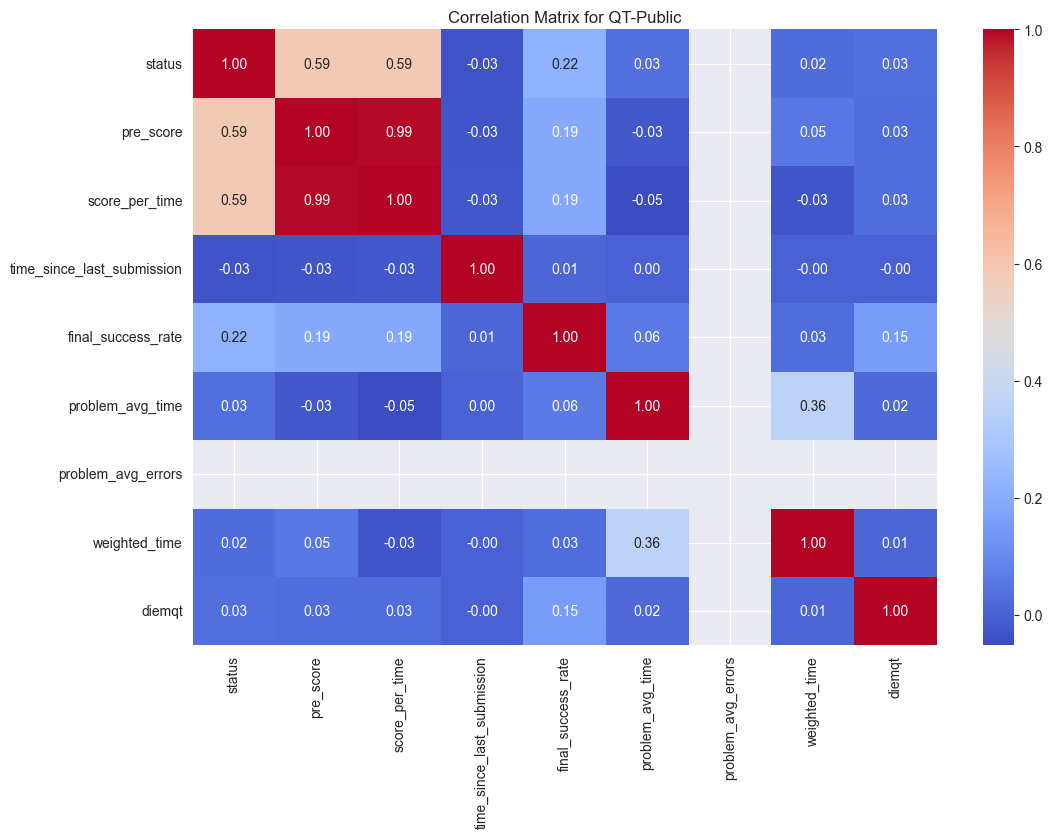

In [30]:
correlation_features = FEATURES_MAPPING["qt-public"] + ["diemqt"]
correlation_data = train_data[correlation_features]

correlation_data = correlation_data.apply(pd.to_numeric, errors='coerce').fillna(0)

corr_matrix = correlation_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for QT-Public")
plt.show()


In [31]:
train_and_predict("TH", FEATURES_MAPPING["th-public"], "th_results.csv", model = 'xgboost')

C:\Users\Admin\AppData\Local\Temp\ipykernel_17300\2161328243.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)


R2-Score for TH: 0.2758035930171666


C:\Users\Admin\AppData\Local\Temp\ipykernel_17300\2161328243.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17300\1277751394.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[target_col] = model.predict(X_test_final)


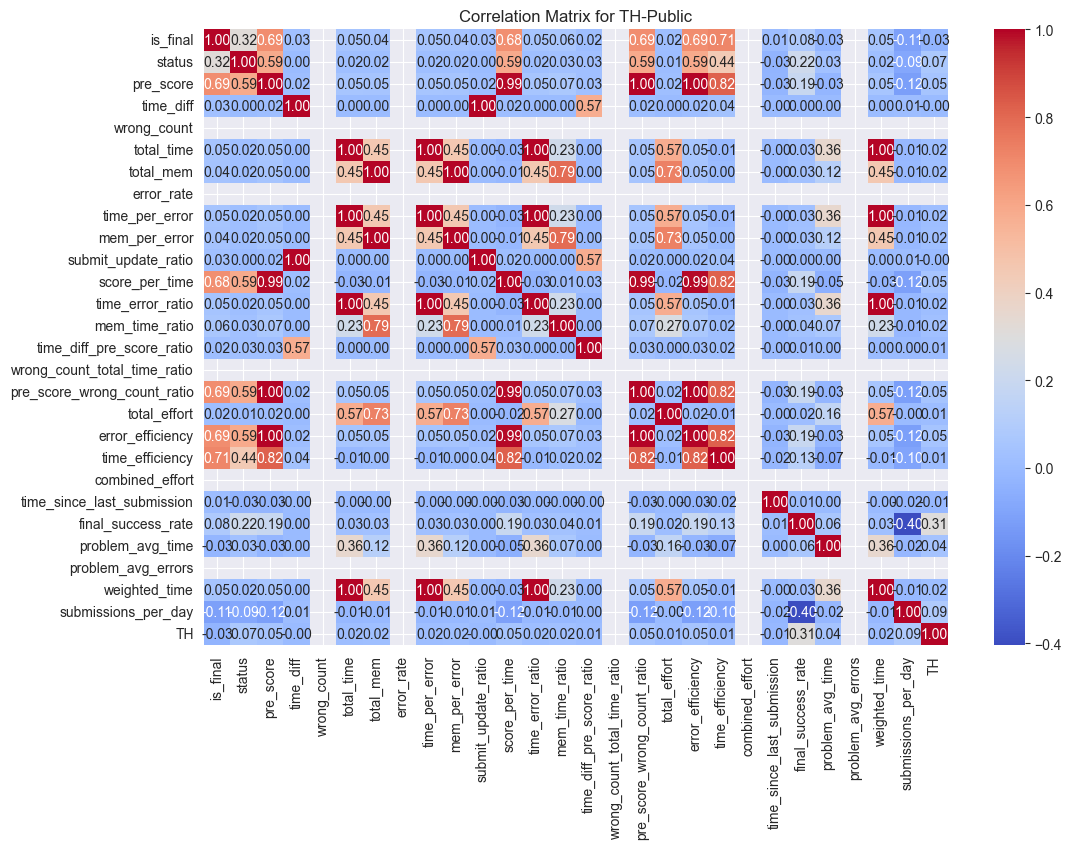

In [33]:
correlation_features = FEATURES_MAPPING["th-public"] + ["TH"]
correlation_data = train_data[correlation_features]

correlation_data = correlation_data.apply(pd.to_numeric, errors='coerce').fillna(0)

corr_matrix = correlation_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for TH-Public")
plt.show()

In [34]:
train_and_predict("CK", FEATURES_MAPPING["ck-public"], "ck_results.csv",model = 'xgboost')

C:\Users\Admin\AppData\Local\Temp\ipykernel_17300\2161328243.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)


R2-Score for CK: 0.298037298926203


C:\Users\Admin\AppData\Local\Temp\ipykernel_17300\2161328243.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17300\1277751394.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[target_col] = model.predict(X_test_final)


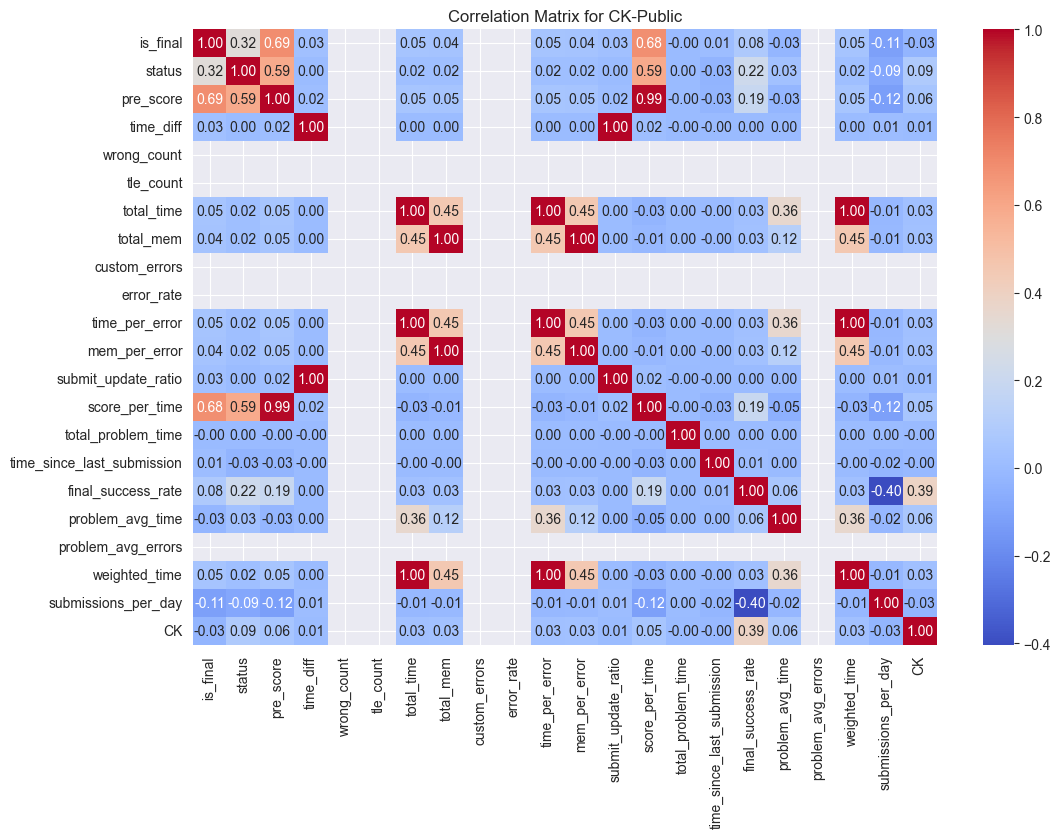

In [35]:
correlation_features = FEATURES_MAPPING["ck-public"] + ["CK"]
correlation_data = train_data[correlation_features]

correlation_data = correlation_data.apply(pd.to_numeric, errors='coerce').fillna(0)

corr_matrix = correlation_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for CK-Public")
plt.show()

In [36]:
train_and_predict("TBTL", FEATURES_MAPPING["tbtl-public"], "tbtl_results.csv", model = 'xgboost')

C:\Users\Admin\AppData\Local\Temp\ipykernel_17300\2161328243.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)


R2-Score for TBTL: 0.23725133493205397


C:\Users\Admin\AppData\Local\Temp\ipykernel_17300\2161328243.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: str(x).strip() if isinstance(x, str) else x)
C:\Users\Admin\AppData\Local\Temp\ipykernel_17300\1277751394.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[target_col] = model.predict(X_test_final)


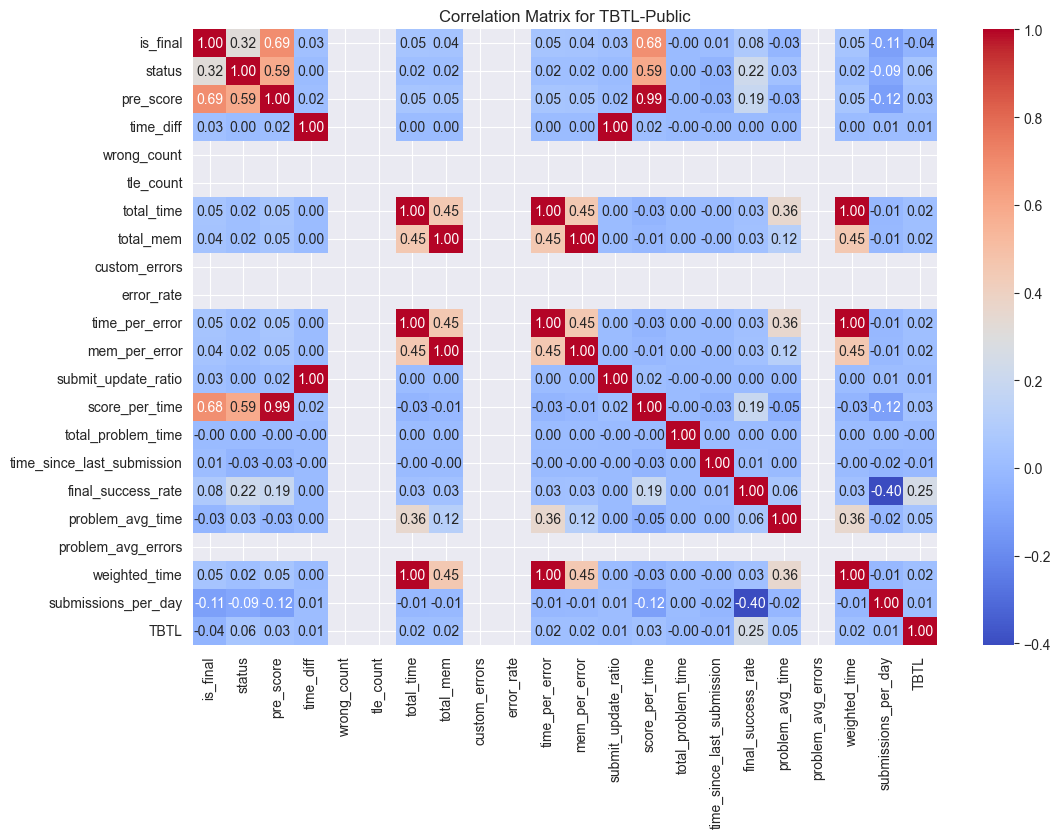

In [37]:
correlation_features = FEATURES_MAPPING["tbtl-public"] + ["TBTL"]
correlation_data = train_data[correlation_features]

correlation_data = correlation_data.apply(pd.to_numeric, errors='coerce').fillna(0)

corr_matrix = correlation_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for TBTL-Public")
plt.show()